In [3]:
import os
import librosa   #для работы с аудио файлами
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #для работы с аудио файлами
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
#Мы используем одномерные массивы, полученные из аудио файлов,поэтому мы используем Conv1D и MaxPooling1D
#Dense используется для подключения всей нейронной сети
#Flattening это процесс преобразования всех результирующих одномерных массивов в один длинный непрерывный линейный вектор.
#Dropout layer используется для регуляризации, где вы случайным образом устанавливаете некоторые размеры входного вектора равными нулю.
from keras.models import Model #Инициализирует модель
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot 
import random
import soundfile as sf

Using TensorFlow backend.


In [5]:
#Для работы был взят готовый датасет из соревнования по распознованию команд
#Так как он находится в архиве, установим разархиватор и разархивируем данные
!apt-get install -y p7zip-full
!7z x ../input/tensorflow-speech-recognition-challenge/train.7z -Y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-3+deb9u1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/tensorflow-speech-recognition-challenge                                                          1 file, 1121103842 bytes (1070 MiB)

Extracting archive: ../input/tensorflow-speech-recognition-challenge/train.7z
--
Path = ../input/tensorflow-speech-recognition-challenge/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

      0% 38 - train/audio/_background_noise_/doing_the_dishes.wa                                                              0% 40 - train/audio

In [6]:
!7z x ../input/tensorflow-speech-recognition-challenge/test.7z -Y


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/tensorflow-speech-recognition-challenge                                                          1 file, 2640679130 bytes (2519 MiB)

Extracting archive: ../input/tensorflow-speech-recognition-challenge/test.7z
--
Path = ../input/tensorflow-speech-recognition-challenge/test.7z
Type = 7z
Physical Size = 2640679130
Headers Size = 1345163
Method = Delta LZMA2:24
Solid = +
Blocks = 3

      0% 116 - test/audio/clip_002c56d95.w                                        0% 263 - test/audio/clip_006bd0d1c.w                                        0% 378 - test/audio/clip_009fa6856.w                                        0% 541 - test/audio/clip_00ef61215.w                                        0% 672 - test/audio/clip_0125959f9.w                        

In [7]:
#Укажем путь до тренировочных данных и посмотрим на слова на которых происходит обучение
train_audio_path = 'train/audio/'
print(len(os.listdir(train_audio_path)))
print(os.listdir(train_audio_path))

31
['up', 'dog', 'yes', 'zero', 'cat', 'seven', 'go', 'stop', 'left', 'bird', 'on', 'one', 'two', 'house', 'off', 'sheila', 'bed', 'right', 'six', 'down', 'eight', 'four', 'five', 'three', 'marvin', 'tree', 'no', '_background_noise_', 'happy', 'wow', 'nine']


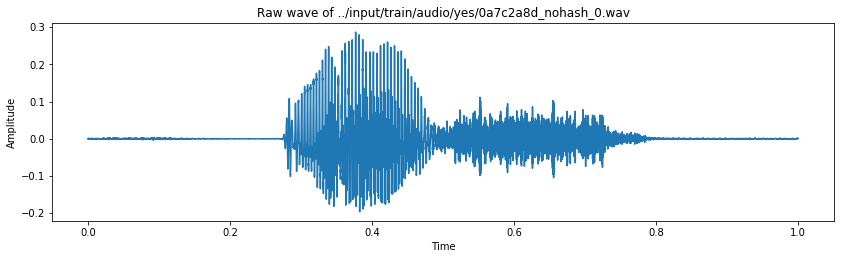

In [8]:
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8)) #FigSize определяет количество пикселей на спектограмме
ax1 = fig.add_subplot(211) #Параметр подзаголовка 2x1 в верхнем левом углу графика
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [9]:
print(sample_rate)
ipd.Audio(samples, rate=sample_rate)

16000


In [5]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

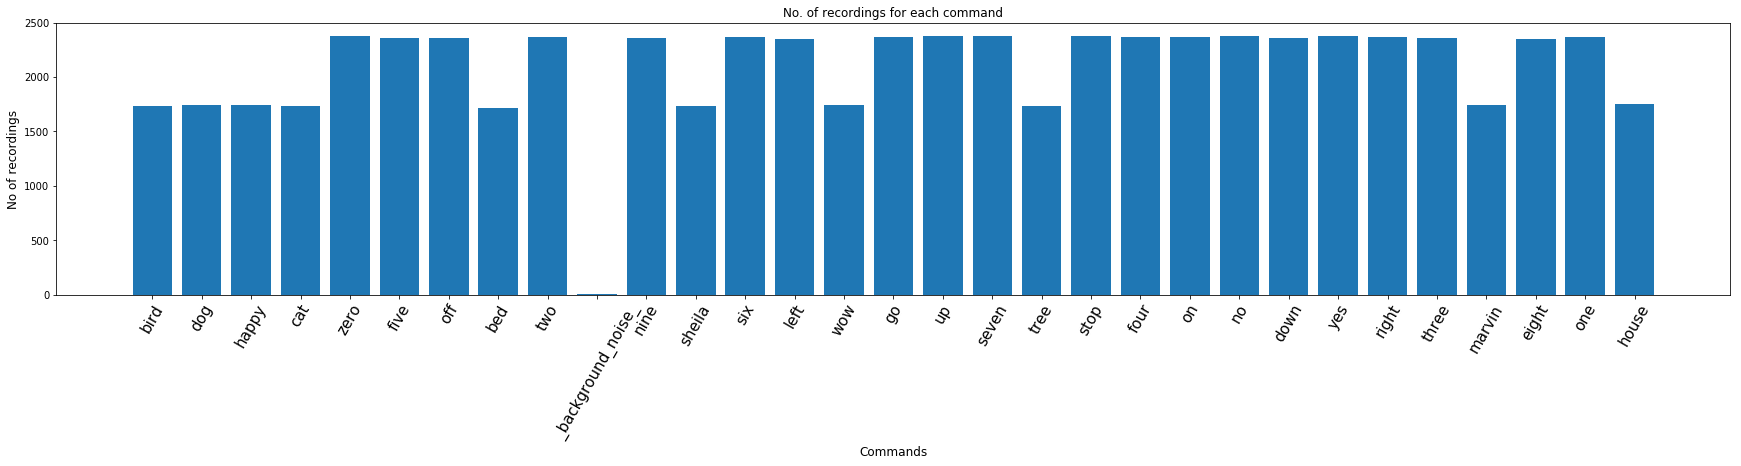

In [6]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "wow", "house", "happy", "tree", "dog", "cat", "bird", 
        "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

(array([1.2000e+01, 1.8000e+01, 1.6600e+02, 1.4700e+02, 3.4300e+02,
        5.8200e+02, 8.5600e+02, 7.1300e+02, 1.2580e+03, 5.3057e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <a list of 10 Patch objects>)

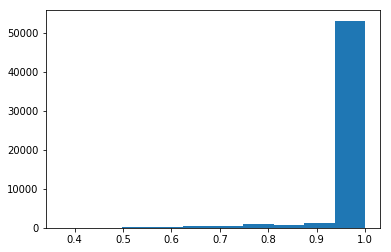

In [7]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [8]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go
wow
house
happy
tree
dog
cat
bird
one
two
three
four
five
six
seven
eight
nine


In [20]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [22]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [25]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [26]:
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [27]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 41127 samples, validate on 10282 samples
Epoch 1/100
41127/41127 [==============================] - 15s 374us/step - loss: 2.6665 - accuracy: 0.1876 - val_loss: 2.0452 - val_accuracy: 0.3733
Epoch 2/100
41127/41127 [==============================] - 12s 299us/step - loss: 1.9500 - accuracy: 0.3758 - val_loss: 1.6596 - val_accuracy: 0.4780
Epoch 3/100
41127/41127 [==============================] - 12s 292us/step - loss: 1.7135 - accuracy: 0.4454 - val_loss: 1.4460 - val_accuracy: 0.5365
Epoch 4/100
41127/41127 [==============================] - 13s 305us/step - loss: 1.5208 - accuracy: 0.5118 - val_loss: 1.2960 - val_accuracy: 0.5917
Epoch 5/100
41127/41127 [==============================] - 12s 295us/step - loss: 1.3378 - accuracy: 0.5752 - val_loss: 1.0703 - val_accuracy: 0.6783
Epoch 6/100
41127/41127 [==============================] - 12s 293us/step - loss: 1.2116 - accuracy: 0.6180 - val_loss: 0.9737 - val_accuracy: 0.7064
Epoch 7/100
41127/41127 [=========================

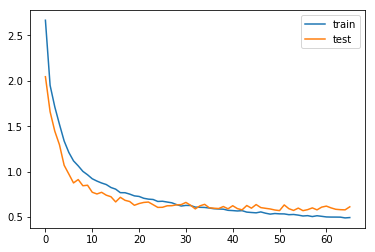

In [28]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
'''from keras.models import load_model
model=load_model('best_model.hdf5')'''

In [29]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [30]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: cat
Text: cat


In [44]:
filepath='test/audio/'
os.path.lexists(filepath)

True

In [42]:
samples, sample_rate = librosa.load(filepath + '/' + '4c7c95de_nohash_1.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [43]:
predict(samples)

'right'